# Chapter 7: Oil Well Performance (IPR Curves)
**Author:** Ade Anggi Naluriawan Santoso

**Objective:**
In this notebook, we will construct **Inflow Performance Relationship (IPR)** curves, which map the production rate ($q$) against the flowing bottom-hole pressure ($P_{wf}$).

**The Concept:**
* **Productivity Index ($J$):** In simple liquid flow (above bubble point), the relationship is a straight line: $q = J(\bar{P}_R - P_{wf})$.
* **The Problem:** Once pressure drops below the **Bubble Point ($P_b$)**, gas breaks out of solution, increasing viscosity and blocking flow paths. The straight line bends into a curve.

We will implement:
1.  **Vogel's Method:** The standard empirical correlation for solution-gas drive reservoirs.
2.  **Fetkovich's Method:** Uses an exponential equation to account for turbulence (non-Darcy flow).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Plotting Style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 7)

## 1. Vogel's Method (1968)

Vogel developed a dimensionless reference curve based on simulation of saturated oil reservoirs. It requires only one flow test point to generate the entire curve.

### The Equation
$$\frac{q_o}{q_{o,max}} = 1 - 0.2 \left( \frac{P_{wf}}{\bar{P}_R} \right) - 0.8 \left( \frac{P_{wf}}{\bar{P}_R} \right)^2$$

Where:
* $q_o$: Oil flow rate at $P_{wf}$.
* $q_{o,max}$: Absolute Open Flow (AOF) potential (rate when $P_{wf} = 0$).
* $\bar{P}_R$: Average Reservoir Pressure.

**Generalized Vogel:**
If the reservoir pressure is **above** the bubble point ($\bar{P}_R > P_b$), the IPR is composite:
1.  **Straight Line:** From $\bar{P}_R$ down to $P_b$ (Single phase liquid).
2.  **Vogel Curve:** From $P_b$ down to $0$ (Two-phase flow).

In [6]:
def calc_vogel_ipr(Pr, Pwf_test, q_test, Pb=None):
    """
    Calculates the IPR curve using Vogel's method.
    Handles both Saturated (Pr <= Pb) and Undersaturated (Pr > Pb) reservoirs.
    """
    if Pb is None: 
        Pb = Pr # Assume saturated if Pb not given
        
    # --- STEP 1: Calculate Productivity Index (J) or q_max ---
    
    if Pr <= Pb:
        # Case A: Saturated Reservoir (The classic Vogel)
        term = 1 - 0.2 * (Pwf_test / Pr) - 0.8 * (Pwf_test / Pr)**2
        q_max = q_test / term
        J_star = 0 # Set to 0 just to be safe, though we won't use it
        
    else:
        # Case B: Undersaturated Reservoir (Composite IPR)
        if Pwf_test >= Pb:
            J = q_test / (Pr - Pwf_test)
        else:
            # Approximation if test point is below Pb
            J = q_test / (Pr - Pwf_test) 
        
        # Calculate Rate at Bubble Point
        qb = J * (Pr - Pb)
        
        # Calculate q_max (AOF) using Vogel below Pb
        q_max = qb + (J * Pb) / 1.8
        J_star = J

    # --- STEP 2: Generate the Curve ---
    pwf_range = np.linspace(0, Pr, 50)
    q_values = []
    
    for p in pwf_range:
        # CORRECTION HERE: 
        # Only use the straight line equation if we are strictly ABOVE the bubble point
        # AND the reservoir is undersaturated.
        if p >= Pb and Pr > Pb:
            # Straight Line Region
            q = J_star * (Pr - p)
        else:
            # Vogel Region
            if Pr <= Pb:
                # Pure Vogel
                q = q_max * (1 - 0.2*(p/Pr) - 0.8*(p/Pr)**2)
            else:
                # Composite Vogel (Shifted)
                qb = J_star * (Pr - Pb)
                q = qb + (q_max - qb) * (1 - 0.2*(p/Pb) - 0.8*(p/Pb)**2)
        
        q_values.append(q)
        
    return pd.DataFrame({'Pwf': pwf_range, 'q': q_values}), q_max

## 2. Fetkovich's Method (1973)

Fetkovich proposed that oil wells, like gas wells, follow a power-law relationship, especially when flow is turbulent (non-Darcy).

### The Equation
$$q_o = C (\bar{P}_R^2 - P_{wf}^2)^n$$

Where:
* $C$: Flow coefficient (capture rock/fluid properties).
* $n$: Turbulence factor (0.5 to 1.0).
    * $n=1.0$: Laminar flow (Darcy).
    * $n=0.5$: Fully turbulent flow.
    * Typical oil wells: $n \approx 0.8 - 1.0$.

To use this, we typically need **two test points** (Isochronal test) to solve for the two unknowns $C$ and $n$, or we assume an $n$ value.

In [3]:
def calc_fetkovich_ipr(Pr, Pwf_test1, q_test1, Pwf_test2, q_test2):
    """
    Calculates IPR using Fetkovich method.
    Requires two test points to determine 'n' and 'C'.
    """
    
    # 1. Calculate n (slope on log-log plot of delta-P^2 vs q)
    # q1 = C(Pr^2 - Pwf1^2)^n
    # q2 = C(Pr^2 - Pwf2^2)^n
    # log(q1/q2) = n * log( (Pr^2 - P1^2) / (Pr^2 - P2^2) )
    
    numerator = np.log10(q_test1 / q_test2)
    denominator = np.log10( (Pr**2 - Pwf_test1**2) / (Pr**2 - Pwf_test2**2) )
    n = numerator / denominator
    
    # 2. Calculate C
    C = q_test1 / ((Pr**2 - Pwf_test1**2)**n)
    
    # 3. Calculate AOF (Absolute Open Flow) at Pwf=0
    AOF = C * (Pr**2 - 0**2)**n
    
    # 4. Generate Curve
    pwf_range = np.linspace(0, Pr, 50)
    q_values = [C * (Pr**2 - p**2)**n for p in pwf_range]
    
    return pd.DataFrame({'Pwf': pwf_range, 'q': q_values}), AOF, n

## 3. Exercise: Comparison of Methods

**Scenario:**
We have an oil well in a saturated reservoir (no gas cap initially, but pressure is low).
* **Reservoir Pressure ($\bar{P}_R$):** 3000 psi
* **Bubble Point ($P_b$):** 3000 psi (Saturated)

**Test Data:**
We performed a multi-rate test:
1.  **Test 1:** $P_{wf} = 2000$ psi, $q = 500$ STB/D
2.  **Test 2:** $P_{wf} = 1000$ psi, $q = 800$ STB/D

**Task:**
1.  Construct the IPR using **Vogel's Method** (using only Test 1).
2.  Construct the IPR using **Fetkovich's Method** (using both tests).
3.  Compare the predicted Absolute Open Flow (AOF).

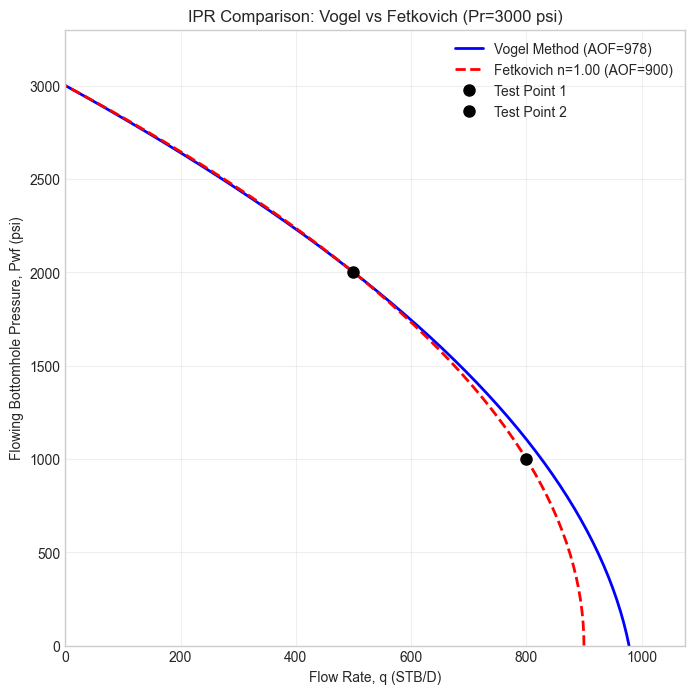

--- Results ---
Vogel AOF:     978.3 STB/D
Fetkovich AOF: 900.0 STB/D
Fetkovich exponent (n): 1.000


In [7]:
# --- INPUTS ---
Pr_res = 3000
Pb_res = 3000 # Saturated case

# Test Point 1
P1 = 2000
q1 = 500

# Test Point 2 (Only needed for Fetkovich)
P2 = 1000
q2 = 800

# --- CALCULATIONS ---

# 1. Vogel (Uses Point 1 only)
df_vogel, aof_vogel = calc_vogel_ipr(Pr_res, P1, q1, Pb=Pb_res)

# 2. Fetkovich (Uses Point 1 and 2)
df_fetk, aof_fetk, n_exp = calc_fetkovich_ipr(Pr_res, P1, q1, P2, q2)

# --- PLOTTING ---
fig, ax = plt.subplots(figsize=(8, 8))

# Plot Curves
ax.plot(df_vogel['q'], df_vogel['Pwf'], 'b-', linewidth=2, label=f'Vogel Method (AOF={aof_vogel:.0f})')
ax.plot(df_fetk['q'], df_fetk['Pwf'], 'r--', linewidth=2, label=f'Fetkovich n={n_exp:.2f} (AOF={aof_fetk:.0f})')

# Plot Test Points
ax.plot(q1, P1, 'ko', markersize=8, label='Test Point 1')
ax.plot(q2, P2, 'ko', markersize=8, label='Test Point 2')

# Formatting (Standard IPR format: Pwf on Y, q on X)
ax.set_xlabel('Flow Rate, q (STB/D)')
ax.set_ylabel('Flowing Bottomhole Pressure, Pwf (psi)')
ax.set_title(f'IPR Comparison: Vogel vs Fetkovich (Pr={Pr_res} psi)')
ax.set_xlim(0, max(aof_vogel, aof_fetk) * 1.1)
ax.set_ylim(0, Pr_res * 1.1)
ax.legend()
ax.grid(True, which='both', alpha=0.3)

plt.show()

print(f"--- Results ---")
print(f"Vogel AOF:     {aof_vogel:.1f} STB/D")
print(f"Fetkovich AOF: {aof_fetk:.1f} STB/D")
print(f"Fetkovich exponent (n): {n_exp:.3f}")

## Analysis of Results

* **Curvature:** Notice that the Vogel curve has a fixed shape (curvature is hardcoded by the 0.2 and 0.8 coefficients).
* **Flexibility:** Fetkovich's curve is flexible. Because $n$ was calculated to be less than 1 (likely around 0.7-0.9 in this example), it bends differently.
* **Test Points:** Fetkovich hits **both** test points exactly (because it used both to calibrate). Vogel hits Test Point 1 exactly, but might miss Test Point 2 slightly because it assumes a standard "average" behavior for all wells.

**Conclusion:**
* Use **Vogel** when you have limited data (e.g., only one test point) and a standard solution-gas drive reservoir.
* Use **Fetkovich** when you have multi-rate test data and want to capture specific turbulence or non-Darcy flow effects.